##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments

In [1]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [3]:
from tools.quantum_tools import quantum_simulator, get_noise_model
from tools.classical_tools import classical_simulator

In [26]:
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, ylim, text, figure
from numpy import linspace, pi, zeros_like, zeros, divide, array, arange, flipud
from seaborn import heatmap
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
from qiskit.visualization import plot_gate_map 

## Probability of all spins up and energy variation
---
### Classical simulation

In [5]:
# Checking if the hamiltonian is correct
spins = 3 # Number of 2-level systems
coupling = 2
frequency = 1

In [6]:
%%time
times = linspace(0, 1, 500)
probabilities, internal_energy, coupling_energy = classical_simulator(times, spins, frequency, coupling)

CPU times: user 78.8 ms, sys: 4.15 ms, total: 82.9 ms
Wall time: 81.9 ms


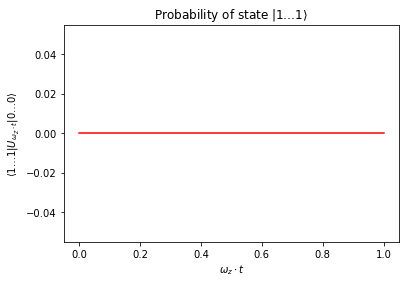

In [7]:
plot(times, probabilities, '-r')
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
show()

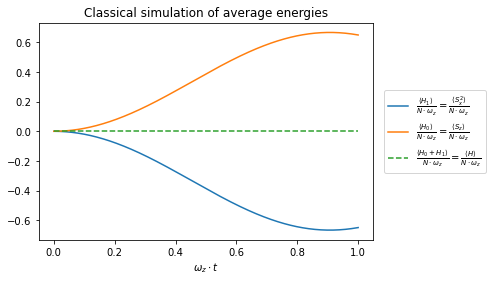

In [8]:
plot(times, coupling_energy, label = r'$\frac{\langle H_1\rangle}{N\cdot\omega_z}=\frac{\langle S_x^2\rangle}{N\cdot\omega_z} $' )    
plot(times, internal_energy, label = r'$\frac{\langle H_0\rangle}{N\cdot\omega_z}=\frac{\langle S_z\rangle}{N\cdot\omega_z} $' )  
plot(times, internal_energy + coupling_energy, '--', label = r'$\frac{\langle H_0 + H_1\rangle}{N\cdot\omega_z}=\frac{\langle H\rangle}{N\cdot\omega_z} $' )  
legend(loc = 'center right', bbox_to_anchor = (1.35, 0.5))
title(r'Classical simulation of average energies')
xlabel(r'$\omega_z \cdot t$')
show()

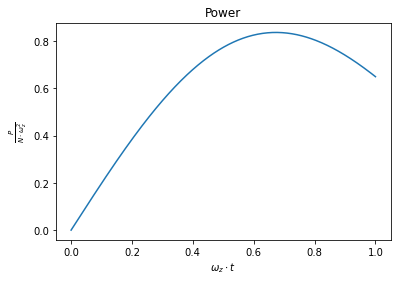

In [9]:
plot(times, divide(internal_energy, times, out = zeros_like(internal_energy), where = times != 0))
title(r'Power')
ylabel(r'$\frac{P}{N\cdot\omega_z^2}$')
xlabel(r'$\omega_z \cdot t$')
show()

In [10]:
%%time
maximum_spins = 7
t = linspace(0, 2, 50)
couplings = arange(0.1, 1.5, 0.1).round(decimals = 2)
maximum_power = array([zeros_like(couplings) for _ in range(maximum_spins - 1)])

for j, g in enumerate(couplings):
    for i in range(2, maximum_spins + 1):
        _, energy, _ = classical_simulator(t, i, frequency, g)
        power = divide(energy, t, out = zeros_like(energy), where = t != 0)
        maximum_power[1 - i][j] = power.max()

CPU times: user 11.9 s, sys: 59.4 ms, total: 12 s
Wall time: 3.02 s


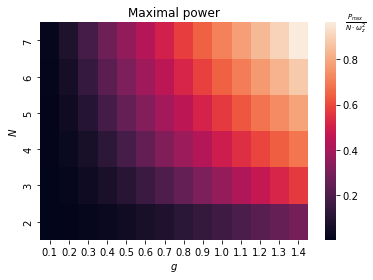

In [11]:
figure = heatmap(maximum_power, xticklabels = couplings, yticklabels = [i for i in range(maximum_spins, 1, -1)])
title('Maximal power')
xlabel(r'$g$')
ylabel(r'$N$')
text(16.5, 0.0, r'$\frac{P_{max}}{N\cdot\omega_z^2}$', horizontalalignment = 'center', verticalalignment = 'center')
show()

### Quantum simulation

In [52]:
# Initialization
quantum_times = linspace(0, 1, 50)
shots = 20000

noise = get_noise_model(1.6e-2, 0.001, 8e-3, 1.6, 4.3e-1, spins, 337e-9)
backend = QasmSimulator(noise_model=noise)
trotter_steps = 4

In [53]:
quantum_probabilities, quantum_internal_energy, quantum_coupling_energy, \
mitigated_quantum_probabilities, mitigated_quantum_internal_energy, mitigated_quantum_coupling_energy = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, backend, shots)

[[9.5280e-01 1.5300e-02 1.4850e-02 3.5000e-04 1.5350e-02 5.0000e-05
  2.0000e-04 0.0000e+00]
 [1.6250e-02 9.5280e-01 2.0000e-04 1.5950e-02 3.0000e-04 1.4950e-02
  0.0000e+00 2.0000e-04]
 [1.5500e-02 1.5000e-04 9.5290e-01 1.6600e-02 2.5000e-04 0.0000e+00
  1.6250e-02 4.0000e-04]
 [2.0000e-04 1.5150e-02 1.5800e-02 9.5050e-01 5.0000e-05 1.0000e-04
  1.5000e-04 1.6750e-02]
 [1.4950e-02 1.5000e-04 3.0000e-04 0.0000e+00 9.5210e-01 1.4900e-02
  1.4900e-02 1.5000e-04]
 [5.0000e-05 1.6200e-02 0.0000e+00 4.0000e-04 1.5600e-02 9.5480e-01
  4.0000e-04 1.3550e-02]
 [2.5000e-04 0.0000e+00 1.5700e-02 2.5000e-04 1.6150e-02 2.5000e-04
  9.5185e-01 1.8050e-02]
 [0.0000e+00 2.5000e-04 2.5000e-04 1.5950e-02 2.0000e-04 1.4950e-02
  1.6250e-02 9.5090e-01]]


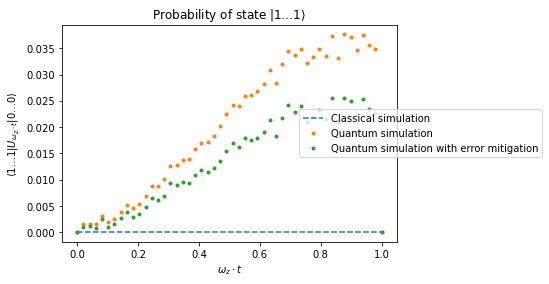

In [54]:
# Plotting
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, quantum_probabilities, '.', label = "Quantum simulation")
plot(quantum_times, mitigated_quantum_probabilities, '.', label = "Quantum simulation with error mitigation")

xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

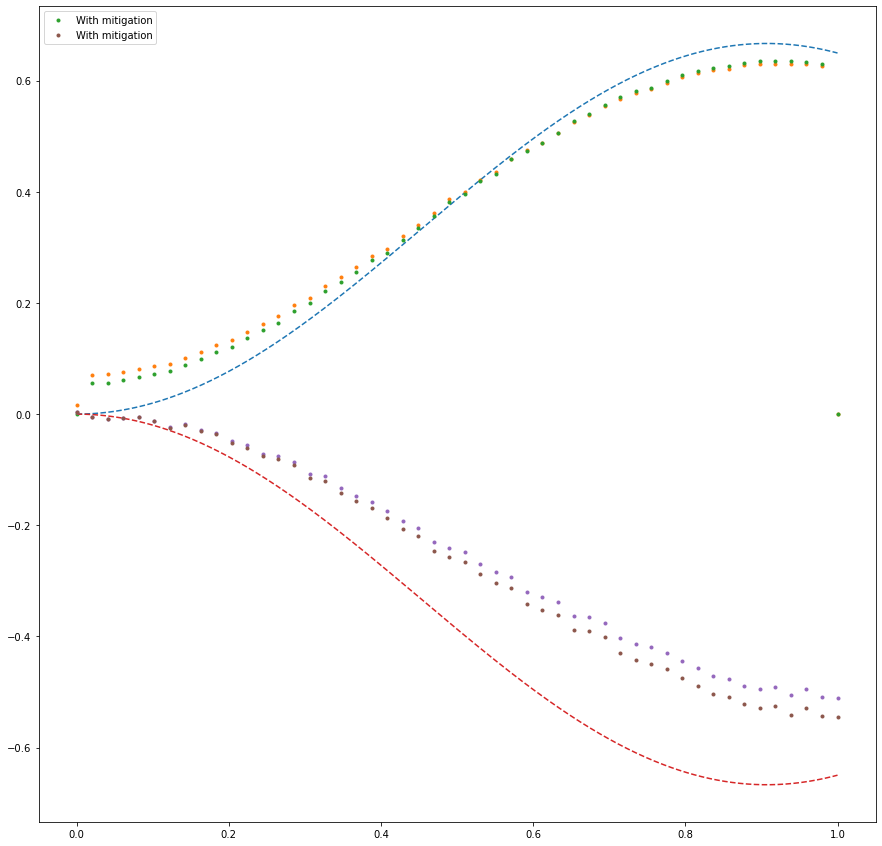

In [55]:
figure(figsize = (15, 15))
plot(times, internal_energy, '--')
plot(quantum_times, quantum_internal_energy, '.')
plot(quantum_times, mitigated_quantum_internal_energy, '.', label = 'With mitigation')
plot(times, coupling_energy, '--')
plot(quantum_times, quantum_coupling_energy, '.')
plot(quantum_times, mitigated_quantum_coupling_energy, '.', label = 'With mitigation')
legend()
show()

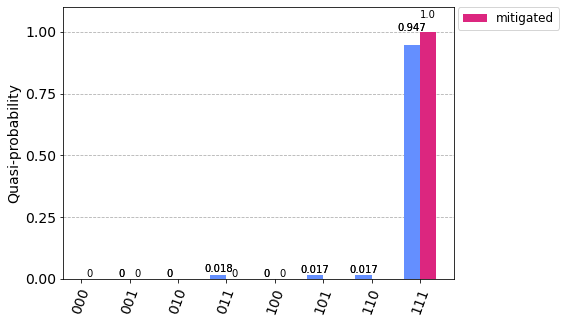

In [81]:
# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()


plot_histogram([raw_counts[0], mitigated_counts[0]], legend=['noisy', 'mitigated'])

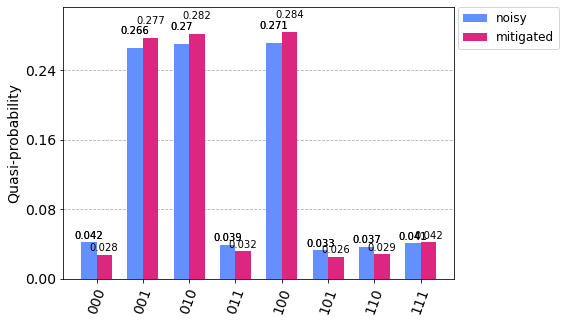

In [82]:
plot_histogram([raw_counts[48], mitigated_counts[48]], legend=['noisy', 'mitigated'])

 ### Simulation on real device

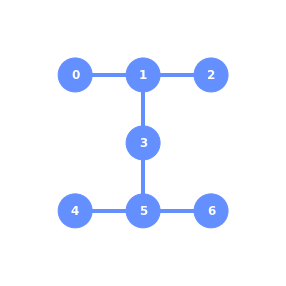

ibm_oslo


In [38]:
if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

backends = IBMQ.providers()[0].backends()
info = backends[-1]
provider = IBMQ.get_provider(hub = info.hub, group = info.group, project = info.project)
device_backend = provider.get_backend(info.name())
display(plot_gate_map(device_backend)) # To visualize the backend hardware map
print(info)

In [ ]:
# Counting
device_probabilities, device_internal_energy, device_coupling_energy = \
quantum_simulator(quantum_times, spins, trotter_steps, frequency, coupling, device_backend, shots)

In [ ]:
plot(times, probabilities, '--', label = "Classical simulation")
plot(quantum_times, device_probabilities, '.', label = "Quantum simulation")
xlabel(r'$\omega_z \cdot t$')
ylabel(r'$\langle 1\dots 1|U_{\omega_Z\cdot t}|0\dots0\rangle$')
title(r'Probability of state $|1\dots1\rangle$')
legend(loc = 'center right', bbox_to_anchor = (1.45, 0.5))
show()

In [ ]:
plot(times, internal_energy, '--')
plot(quantum_times, device_internal_energy, '.')
plot(times, coupling_energy, '--')
plot(quantum_times, device_coupling_energy, '.')
show()